# 3. Feedforward neural networks (perceptrons)
##  3.1 MNIST Handwritten Digits recognition using pytorch.


##### Importing modules:
* `numpy` for data processing
* `pandas` for convenient data loading ang managing
* `seaborn` and `matplotlib` for data and images visualiazation
* `torch` for ML models implementation
* `torchvision` for image processing
* load MNIST from included datasets
* `tqdm` for progress bar in loops

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torch.nn as nn 
import torch.nn.functional as func

from torch.utils.data import DataLoader, random_split

import torchvision.transforms as tf
from torchvision.utils import make_grid
from torchvision.datasets import MNIST

from tqdm.notebook import tqdm
import time 

Downloading datasets and converting PIL.Image object to PyTorch tensors. Split training set into train and validation sets, creating data_loaders:

In [2]:
# load data
dataset_train = MNIST(root = '', transform=tf.ToTensor(), download=True, train=True)
dataset_test = MNIST(root = '', transform=tf.ToTensor(), download=True, train=False)

# split into validation and train set
ds_train, ds_val = random_split(dataset_train, [55000, 5000])

batch_size=100

# crate data loaders
train_dloader = DataLoader(ds_train, batch_size, shuffle=True)
val_dloader = DataLoader(ds_val, batch_size, shuffle=False)
test_dloader = DataLoader(dataset_test, 1)

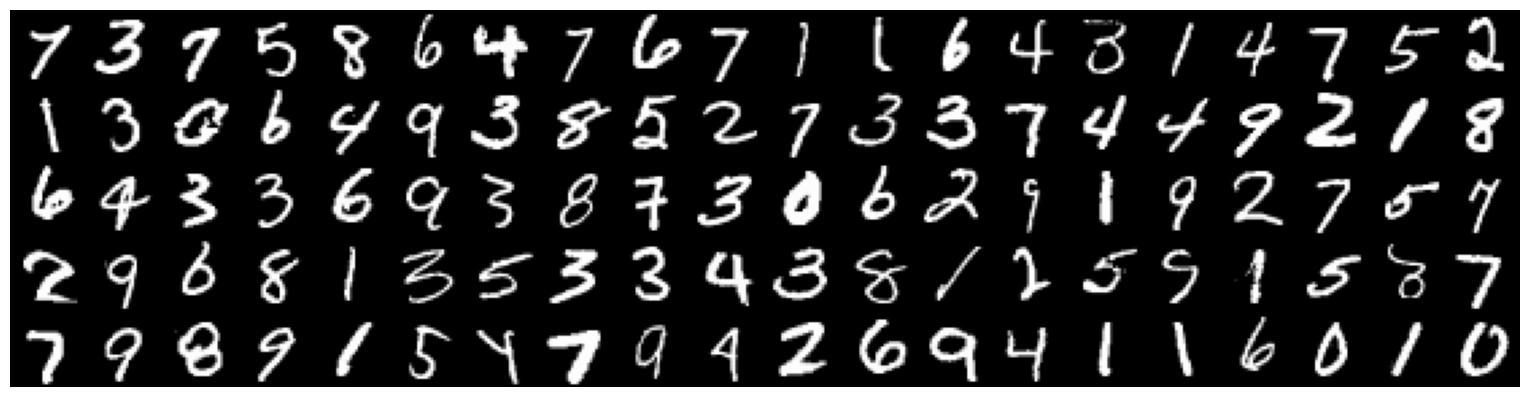

In [3]:
# data visualization (plotting one batch)

fig = plt.figure(figsize=(20,5), dpi=100)
plt.axis('off')
for img, title in train_dloader:
    plt.imshow(make_grid(img, nrow=20, padding=0).permute((1, 2, 0)), cmap='gray')
    break


#### Create neural network class with one hidden layer
`Perceptron` inherited from `Model` class, using `Linear` model for each layer and `Sigmoid` as an activation function and `cross_entropy` as a loss function


In [4]:
def accuracy(predictions, targets):
    a, preds = torch.max(predictions, dim=1)
    return torch.tensor(torch.sum(preds == targets).item() / len(preds))

class Perceptron(nn.Module):
    def __init__(self, input_ncount, hidden_ncount, out_ncount):
        # init parent constructor
        super().__init__()
        # create regression models for layers
        self.model1 = nn.Linear(input_ncount, hidden_ncount)
        self.model2 = nn.Linear(hidden_ncount, out_ncount)
 
    def forward(self, inputs):
        # flat the image tensors to 1D (1x28x28 to 784)
        inputs_flat = inputs.view(inputs.size(0), -1)
        # compute first-layer outs
        hidden_input = torch.sigmoid(self.model1(inputs_flat))
        # return predictions
        return self.model2(hidden_input)
        
    def get_loss(self, batch):
        inputs, target = batch 
        pred = self.forward(inputs)    
        return func.cross_entropy(pred, target)     
    
    def get_validation(self, batch):
        inputs, target = batch 
        pred = self.forward(inputs)    
        return accuracy(pred, target)  
    
    

#### Create fitting and accuracy evaluation functions
`accuracy_evaluation` returns mean accuracy for validation set,
`fitting` learns the model with entered arguments 

In [5]:
def accuracy_evaluation(model, validation_data_loader):
    result = [model.get_validation(batch) for batch in validation_data_loader]
    acc_mean = np.array(result).mean()
    return acc_mean

def fitting(model, train_data_loader, val_data_loaader, optimizer, epochs, alpha):
    accuracy_stat = []
    optim = optimizer(model.parameters(), alpha)    
    for epoch in tqdm(range(epochs), 'Learning'):
        time.sleep(0.01)
        for batch in train_data_loader:
            loss = model.get_loss(batch)
            loss.backward()
            optim.step()
            optim.zero_grad() 
        # validation
        accuracy = accuracy_evaluation(model, val_data_loaader)
        accuracy_stat += [accuracy]
        print('Epoch: {}, accuracy: {}, loss: {}'.format(epoch+1, accuracy, loss))
    return np.array(accuracy_stat)

In [6]:
# create percertron
perceptron = Perceptron(784, 80, 10)

In [12]:
# learinng model 
stat = fitting(perceptron, train_dloader, val_dloader, torch.optim.SGD, 5, 0.5)

Learning:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1, accuracy: 0.9526000022888184, loss: 0.11005473136901855
Epoch: 2, accuracy: 0.9563999772071838, loss: 0.13390198349952698
Epoch: 3, accuracy: 0.9553999900817871, loss: 0.11431802064180374
Epoch: 4, accuracy: 0.9602000713348389, loss: 0.06570138782262802
Epoch: 5, accuracy: 0.9625999927520752, loss: 0.0419856421649456


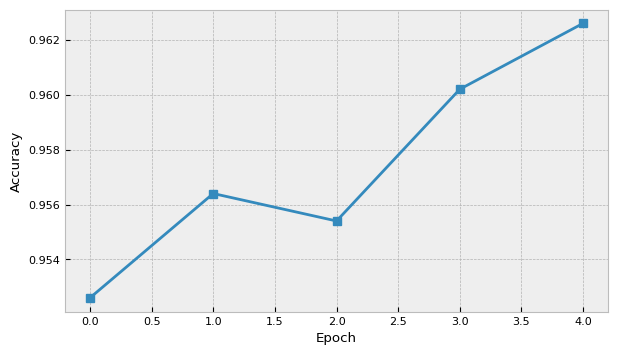

In [13]:
#plotting accuracy during learning
fig = plt.figure(figsize=(7, 4), dpi=100)
plt.style.use('bmh')
ax = fig.add_subplot(111)

line = ax.plot(stat, label='Loss', marker='s')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.rcParams.update({'font.size': 8})

plt.savefig("perceptron_accuracy.png")
plt.show()

#### Checking accuracy of learned model on test dataset:

In [14]:
stat_ac = []
for batch in tqdm(test_dloader, 'Procesing'):
    x, y = batch
    acc = accuracy(perceptron.forward(x), y)
    stat_ac += [acc]
print('Average accuracy: {}%'.format((np.array(stat_ac).mean()*100).round(1)))
    

Procesing:   0%|          | 0/10000 [00:00<?, ?it/s]

Average accuracy: 96.6%


#### Defining function for single-image recognition:

In [15]:
def recognize(img, model):
    pred = model(img).detach().numpy()
    return np.where(pred == pred.max())[1][0]

Real: 4, Predicted: 4


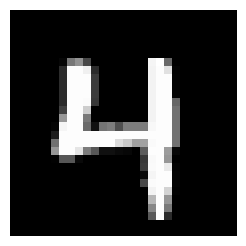

In [19]:
rand = np.random.randint(0,10000)
img, title = dataset_test[rand][0], dataset_test[rand][1]
print('Real: {}, Predicted: {}'.format(title, recognize(img, perceptron)))

fig = plt.figure(figsize=(3, 3), dpi=100)
plt.axis('off')
plt.imshow(img[0], cmap='gray')
